<img src="https://uniconexed.org/wp-content/uploads/2022/03/Tec-de-Monterrey-logo-horizontal-blue.png" alt="Logo Tecnológico de Monterrey" width="500" />

**Maestría en Inteligencia Artificial Aplicada**

**Proyecto Integrador**

Avance 1. Análisis exploratorio de datos


Equipo #15:

*   A01795654 - Raúl Astorga Castro
*   A01795579 - Edson Misael Astorga Castro
*   A08877728 - Dianna Raquel Pérez Güereque


Profesores:

*   Dra. Grettel Barceló Alonso
*   Dr. Luis Eduardo Falcón Morales

01 de Febrero de 2026

# 1. Introducción

Este entregable corresponde al **Análisis Exploratorio de Datos (EDA)**, cuyo propósito es **describir, entender y depurar** el conjunto de datos antes de proponer transformaciones o features para modelado. En proyectos de NLP/RAG (como este caso de TecBot multiagente), el “dataset” suele ser una **base de conocimiento textual** (artículos, FAQs, páginas institucionales), por lo que el EDA se enfoca en:

1) **Calidad y completitud**: valores faltantes, duplicados, consistencia de identificadores y distribución de longitudes.  
2) **Atípicos y sesgos**: documentos demasiado largos/cortos o distribuciones muy sesgadas que afectan chunking, embeddings y recuperación.  
3) **Alta cardinalidad**: categorías o campos con muchos valores únicos que dificultan el análisis y pueden inflar dimensionalidad si se codifican de forma ingenua.  
4) **Señales del texto**: frecuencias, n-gramas y similitud para detectar redundancia y temas dominantes.  
5) **Legibilidad**: indicadores para estimar claridad/entendibilidad del contenido, útil para guías al usuario y homogeneidad del conocimiento.

Este enfoque mantiene el espíritu del EDA clásico y lo adapta a un contexto de **documentos textuales** que alimentan un pipeline de RAG/multiagentes (Tukey, 1977; Wickham, 2014).


# 2. Instalación de dependencias



In [154]:
!pip install textstat


# 3. Importación de librerías

In [155]:
# -------------------------------------------------------------------------
# IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN
# Se importan herramientas para manipulación de datos, visualización y
# procesamiento de lenguaje natural (NLP).
#
# Específicamente:
# - textstat: Para métricas de legibilidad (importante para la UX del chatbot).
# - nltk/wordcloud: Para tokenización y análisis de frecuencias (Señales del texto).
# -------------------------------------------------------------------------

import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import textstat
import nltk
import re

from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

# 4. Inspección rápida de columnas y datos

La inspección inicial permite validar rápidamente:

- **Esquema** (columnas disponibles y tipos de dato) para detectar errores de parseo o carga.
- **Rangos y valores típicos** para identificar inconsistencias.
- **Primeras señales de limpieza** (IDs vacíos, campos con formato irregular).

En EDA, esta fase es clave para evitar “asumir” que los datos ya vienen listos para análisis y para decidir qué transformaciones o validaciones aplicar después (p. ej., normalización de texto, deduplicación o imputación), siguiendo el enfoque exploratorio propuesto por Tukey (1977).

In [156]:
# -------------------------------------------------------------------------
# CARGA DE LA BASE DE CONOCIMIENTO
# Se carga el dataset que contiene los artículos y FAQs que alimentarán a los
# agentes. Se realiza una verificación inicial de dimensiones.
# -------------------------------------------------------------------------

# Carga del archivo fuente (Excel de artículos de conocimiento)
df=pd.read_excel('./articulos_conocimiento_download20260128.xlsx')

# Validación de integridad de la carga (Filas = Documentos, Columnas = Metadatos)
print('Filas (Documentos):', df.shape[0], '| Columnas (Metadatos):', df.shape[1])
df.head(3)

Filas (Documentos): 303 | Columnas (Metadatos): 29


,Id,PublishStatus,VersionNumber,IsLatestVersion,IsVisibleInApp,CreatedDate,CreatedBy,CreatedBy.Name,LastModifiedDate,LastModifiedBy,...,FirstPublishedDate,LastPublishedDate,ArticleCreatedDate,ArticleMasterLanguage,ArticleTotalViewCount,Cuerpo_del_Articulo__c,Introduccion__c,Aplica__c,Fechas__c,Proceso__c
0,ka1U700000025NOIAY,Online,1,True,True,2026-01-12T03:19:53.000+0000,[User],Diana Leticia Alcala Armenta,2026-01-28T16:04:19.000+0000,[User],...,2026-01-28T16:04:19.000+0000,2026-01-28T16:04:19.000+0000,2026-01-12T03:19:52.000+0000,es_MX,1,"Consultoría urbana, planeación y gestión terri...",NaN,NaN,NaN,NaN
1,ka1U700000025NLIAY,Online,1,True,True,2026-01-12T03:19:53.000+0000,[User],Diana Leticia Alcala Armenta,2026-01-28T16:04:19.000+0000,[User],...,2026-01-28T16:04:19.000+0000,2026-01-28T16:04:19.000+0000,2026-01-12T03:19:52.000+0000,es_MX,1,Porque aquí aprendes a transformar ciudades co...,NaN,NaN,NaN,NaN
2,ka1U700000025JnIAI,Online,1,True,True,2026-01-12T03:19:18.000+0000,[User],Diana Leticia Alcala Armenta,2026-01-28T16:04:19.000+0000,[User],...,2026-01-28T16:04:19.000+0000,2026-01-28T16:04:19.000+0000,2026-01-12T03:19:17.000+0000,es_MX,1,Tasa anual fija durante toda la vida del prést...,NaN,NaN,NaN,NaN


In [157]:
# -------------------------------------------------------------------------
# REDUCCIÓN DE DIMENSIONALIDAD Y SELECCIÓN DE CARACTERÍSTICAS
# El dataset original contiene metadatos administrativos (IDs, fechas de sistema)
# que no aportan valor semántico al modelo LLM.
#
# Estrategia:
# Se conservan únicamente las variables con contenido textual rico y
# referencias clave para la recuperación (RAG).
# -------------------------------------------------------------------------

# Inspección preliminar de todas las columnas disponibles
display(df.columns)

# Estadisticas descriptivas
print("\n--- Estadísticas Descriptivas para Variables Cuantitativas ---")
display(df.describe().T)

print("\n--- Estadísticas Descriptivas para Variables Cualitativas ---")
display(df.describe(include='object').T)

Index(['Id', 'PublishStatus', 'VersionNumber', 'IsLatestVersion',
       'IsVisibleInApp', 'CreatedDate', 'CreatedBy', 'CreatedBy.Name',
       'LastModifiedDate', 'LastModifiedBy', 'LastModifiedBy.Name',
       'SystemModstamp', 'Language', 'Title', 'UrlName', 'ArchivedDate',
       'Summary', 'LargeLanguageModel', 'ArticleNumber', 'FirstPublishedDate',
       'LastPublishedDate', 'ArticleCreatedDate', 'ArticleMasterLanguage',
       'ArticleTotalViewCount', 'Cuerpo_del_Articulo__c', 'Introduccion__c',
       'Aplica__c', 'Fechas__c', 'Proceso__c'],
      dtype='object')


--- Estadísticas Descriptivas para Variables Cuantitativas ---


,count,mean,std,min,25%,50%,75%,max
VersionNumber,303.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0
ArchivedDate,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Summary,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LargeLanguageModel,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArticleNumber,303.0,1817.0,87.612784,1666.0,1741.5,1817.0,1892.5,1968.0
ArticleTotalViewCount,303.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0
Introduccion__c,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aplica__c,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fechas__c,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Proceso__c,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



--- Estadísticas Descriptivas para Variables Cualitativas ---


,count,unique,top,freq
Id,303,303,ka1U700000025IeIAI,1
PublishStatus,303,1,Online,303
CreatedDate,303,3,2026-01-12T03:19:53.000+0000,129
CreatedBy,303,1,[User],303
CreatedBy.Name,303,1,Diana Leticia Alcala Armenta,303
LastModifiedDate,303,62,2026-01-28T16:04:06.000+0000,8
LastModifiedBy,303,1,[User],303
LastModifiedBy.Name,303,1,Diana Leticia Alcala Armenta,303
SystemModstamp,303,63,2026-01-28T16:04:06.000+0000,8
Language,303,1,es_MX,303


In [158]:
# Selección final de features relevantes para el modelado
df = df[['Title', 'UrlName', 'ArticleNumber', 'Cuerpo_del_Articulo__c']]

# Vista preliminar del dataset
df.head()

,Title,UrlName,ArticleNumber,Cuerpo_del_Articulo__c
0,Urbanismo - ¿Dónde podrás trabajar?,urbanismo-oportunidades,1968,"Consultoría urbana, planeación y gestión terri..."
1,Urbanismo - ¿Por qué estudiar Urbanismo en el ...,urbanismo-porque-estudiar,1955,Porque aquí aprendes a transformar ciudades co...
2,Ventajas del préstamo educativo,ventajas-prestamo-educativo,1745,Tasa anual fija durante toda la vida del prést...
3,Vida y Acompañamiento en PrepaTec,vida-acompanamiento-prepatec,1695,"LiFE: actividades de arte, deporte, liderazgo ..."
4,¿Cómo se paga el Préstamo Educativo?,prestamo-educativo-como-pagar,1782,Durante estudios: pago semestral fijo de $500 ...


# 5. Análisis de Estructura y Completitud

En una base de conocimiento para RAG, los problemas más comunes antes de modelar son:

- **Valores faltantes** en campos críticos (título, URL, cuerpo): afectan indexación, recuperación y evaluación.
- **Duplicados** exactos o semánticos: introducen ruido, sesgan métricas y pueden producir respuestas repetidas.
- **Outliers** (longitudes extremas): suelen indicar necesidad de chunking o errores de formato.
- **Sesgo en distribuciones**: algunas variables (p. ej., longitud de documentos) tienden a colas largas; analizarlo ayuda a decidir transformaciones (ej. `log1p`).
- **Alta cardinalidad**: categorías con miles de valores únicos pueden dificultar reporteo y, si se codifican, pueden inflar dimensionalidad.

Estas revisiones corresponden a prácticas estándar de EDA y preparación de datos, especialmente relevantes cuando el objetivo es mejorar generalización y reducir complejidad (Tukey, 1977; Wickham, 2014).

In [159]:
# -------------------------------------------------------------------------
# CORRECCIÓN DE PROBLEMAS EN LOS DATOS (VALORES FALTANTES)
# En un sistema RAG, un documento sin contenido ("Cuerpo") es ruido que puede
# generar alucinaciones o recuperaciones fallidas.
#
# Estrategia:
# 1. Identificar patrones de ausencia.
# 2. Eliminar registros donde el contenido crítico sea nulo.
# -------------------------------------------------------------------------

print("--- Análisis de Valores Nulos ---")
display(df.isnull().sum())
print("-" * 30)

--- Análisis de Valores Nulos ---


,0
Title,0
UrlName,0
ArticleNumber,0
Cuerpo_del_Articulo__c,0


------------------------------


In [160]:
# --- Patrones simples de ausencia (missingness patterns) ---
# Además de contar faltantes, interesa saber si "ocurren juntos" en las mismas filas
# (p. ej., si cuando falta UrlName también falta Title).
missing_cols = df.columns[df.isnull().any()].tolist()

if len(missing_cols) >= 2:
    miss_matrix = df[missing_cols].isnull().astype(int)
    miss_corr = miss_matrix.corr()
    display(miss_corr)
    print("Sugerencia: correlaciones altas entre columnas faltantes pueden indicar un problema sistemático de extracción o scraping.")
else:
    print("No hay suficientes columnas con NA para analizar patrones de ausencia.")

No hay suficientes columnas con NA para analizar patrones de ausencia.


In [161]:
# Convertimos a string para evitar errores con NaN
df['Cuerpo_del_Articulo__c'] = df['Cuerpo_del_Articulo__c'].fillna('').astype(str)

df['char_count'] = df['Cuerpo_del_Articulo__c'].str.len()
df['word_count'] = df['Cuerpo_del_Articulo__c'].apply(lambda x: len(x.split()))

print('--- Estadísticas de longitud del artículo ---')
display(df[['char_count','word_count']].describe(percentiles=[.5,.75,.9,.95,.99]))


--- Estadísticas de longitud del artículo ---


,char_count,word_count
count,303.000000,303.000000
mean,304.198020,44.013201
std,201.313601,32.300736
min,24.000000,1.000000
50%,270.000000,38.000000
75%,389.000000,57.500000
90%,571.800000,87.000000
95%,670.400000,102.000000
99%,1026.400000,138.960000
max,1440.000000,242.000000


In [162]:
df['Category'] = df['Title'].str.split(' - | ').str[0].str.replace('¿', '')

print('Cardinalidad (categorías únicas):', df['Category'].nunique())
print("\nDistribución por Categoría Tentativa")
display(df['Category'].value_counts().head(20))

Cardinalidad (categorías únicas): 44

Distribución por Categoría Tentativa


,count
Category,
Beca,108
Admisiones,10
Modelo,9
Proceso,9
Licenciatura,9
Psicología,8
Gobierno,7
Nutrición,7
Prepatec,7


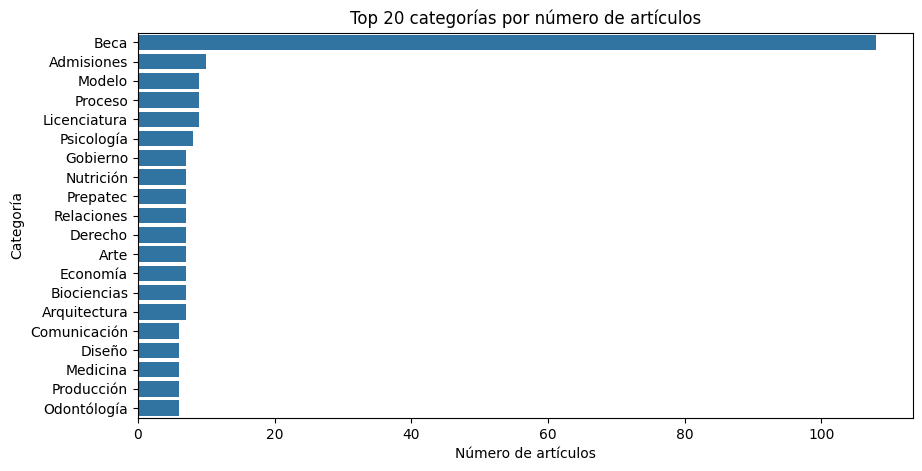

In [163]:
# Visualización: conteo por categoría
top_n = 20
top_cats = df['Category'].value_counts().head(top_n).index
plot_df = df[df['Category'].isin(top_cats)].copy()
plt.figure(figsize=(10,5))
sns.countplot(data=plot_df, y='Category', order=top_cats)
plt.title(f'Top {top_n} categorías por número de artículos')
plt.xlabel('Número de artículos')
plt.ylabel('Categoría')
plt.show()


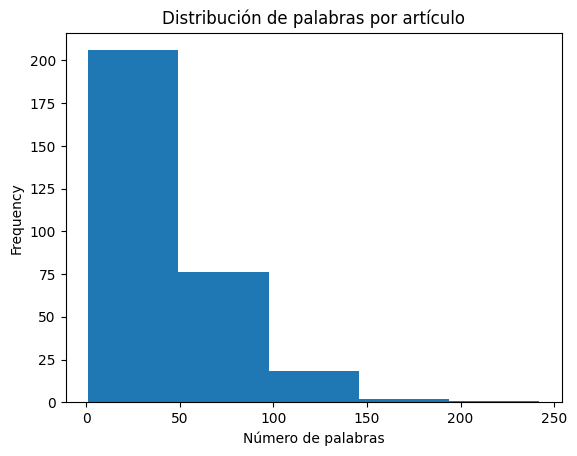

In [164]:
# Distribución univariante: palabras por artículo (detección de sesgo y atípicos)
df['word_count'].plot(kind='hist', bins=5, title='Distribución de palabras por artículo')
plt.xlabel('Número de palabras')
plt.show()

## 5.1 Duplicados y consistencia de identificadores

En bases de conocimiento para RAG, **duplicados** o artículos casi duplicados aumentan ruido, generan respuestas repetidas y pueden sesgar métricas de evaluación. Por eso es importante revisar:
- duplicados exactos por identificador (p. ej., `ArticleNumber`, `UrlName`)
- duplicados exactos de texto
- artículos extremadamente cortos (posibles placeholders) o extremadamente largos (posibles copias/pegados masivos)

Estas verificaciones forman parte del proceso de limpieza y estandarización previa al análisis/modelado, consistente con prácticas de preparación de datos (Wickham, 2014).


In [165]:
# Duplicados exactos por claves
for key in ['ArticleNumber', 'UrlName', 'Title', 'Cuerpo_del_Articulo__c']:
    if key in df.columns:
        dup = df.duplicated(subset=[key]).sum()
        print(f'Duplicados por {key}:', dup)


Duplicados por ArticleNumber: 0
Duplicados por UrlName: 0
Duplicados por Title: 1
Duplicados por Cuerpo_del_Articulo__c: 6


In [166]:
# Duplicados (por Title)
print('Duplicados por Title:')
if 'Title' in df.columns:
    display(df[df.duplicated(subset=['Title'], keep=False)].sort_values('Title')['Title'].head(10))

Duplicados por Title:


,Title
6,Sobre PrepaTec
10,Sobre PrepaTec


In [167]:
# Duplicados (por Cuerpo_del_Articulo__c)
print('Duplicados por Cuerpo_del_Articulo__c:')
if 'Cuerpo_del_Articulo__c' in df.columns:
    display(df[df.duplicated(subset=['Cuerpo_del_Articulo__c'], keep=False)].sort_values('Cuerpo_del_Articulo__c')['Cuerpo_del_Articulo__c'].head(20))

Duplicados por Cuerpo_del_Articulo__c:


,Cuerpo_del_Articulo__c
226,1. Ingresa a https://solicitud.tec.mx\n2. Acce...
268,1. Ingresa a https://solicitud.tec.mx\n2. Acce...
198,1. Ingresa a solicitud.tec.mx. \n2. Da clic en...
257,1. Ingresa a solicitud.tec.mx. \n2. Da clic en...
6,"Aquí comienzas a descubrir tu vocación, desarr..."
10,"Aquí comienzas a descubrir tu vocación, desarr..."
229,Para mantener la beca deberás: \nAprobar todas...
231,Para mantener la beca deberás: \nAprobar todas...
271,Para mantener la beca deberás: \nAprobar todas...
35,https://tec.mx/sites/default/files/inline-file...


## 5.2 Atípicos (outliers) en longitud y legibilidad

En texto, los atípicos suelen indicar:
- artículos muy largos que requieren **chunking**,
- artículos muy cortos que no aportan contexto suficiente,
- errores de formato (HTML pegado, tablas, ruido, etc).

Para detección exploratoria usamos reglas robustas basadas en cuantiles (IQR), tradicionales en EDA para identificar observaciones fuera de los rangos esperados y priorizar revisión (Tukey, 1977).

Outliers por IQR (word_count): 11


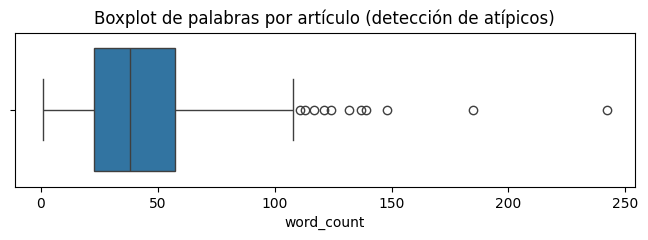

,Title,word_count,char_count
237,Beca Socioeconómica - ¿Cómo solicitarla?,242,1440
46,Proceso general de solicitud (Beca y/o Préstamo),185,1083
254,Beca al Talento en Liderazgo Profesional,148,1065
171,Beca Tlento Artístico PrepaTec - Disciplinas A...,139,1029
256,Beca al Talento Emprendedor Profesional,137,877
267,Beca al Talento Artístico PrepaTec,132,899
247,Beca Líderes del Mañana LATAM,124,874
197,"Beca Talento Creativo Escuela de Arquitectura,...",121,783
255,Beca al Talento en Liderazgo PrepaTec,117,762
221,Beca Talento Artístico PrepaTec - Requisitos g...,113,713


,Title,word_count,char_count
38,Profesional - Lineamientos para Evaluación Ini...,1,78
37,Profesional - Normas Académicas Generales y Po...,1,91
36,Profesional - Reglamento de Admisiones para Pr...,1,103
39,Profesional - Becas y Préstamos Educativos,1,79
35,Profesional - Reglamento de Servicio Social,1,78
60,Prepatec - Reglamento académico PrepaTec,1,123
61,Prepatec - Normas académicas y políticas,1,124
54,Prepatec - Reglamento de programas internacion...,1,134
64,Prepatec - Becas y préstamos educativos,1,118
63,Prepatec - Calendario escolar 2025-2026,1,109


In [168]:
# -------------------------------------------------------------------------
# ANÁLISIS DE OUTLIERS: DISTRIBUCIÓN DE LONGITUD DE TEXTO
# Detectar documentos excesivamente cortos (poca información) o excesivamente
# largos (posible pérdida de contexto en el LLM o necesidad de chunking agresivo).
# -------------------------------------------------------------------------

# Cálculo de longitud en caracteres/palabras

# Detección simple de outliers por IQR en word_count
q1 = df['word_count'].quantile(0.25)
q3 = df['word_count'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

outliers = df[(df['word_count'] < lower) | (df['word_count'] > upper)]
print('Outliers por IQR (word_count):', outliers.shape[0])

# Visualización de la distribución
plt.figure(figsize=(8,2))
sns.boxplot(x=df['word_count'])
plt.title('Boxplot de palabras por artículo (detección de atípicos)')
plt.show()

# Mostrar top-10 más largos y más cortos
display(df.sort_values('word_count', ascending=False)[['Title','word_count','char_count']].head(10))
display(df.sort_values('word_count', ascending=True)[['Title','word_count','char_count']].head(10))


## 5.3 Cardinalidad en variables categóricas

La **alta cardinalidad** (muchos valores únicos en una variable) complica:

- reporteo (demasiadas categorías),
- codificación para ML (p. ej., one-hot puede disparar dimensionalidad),
- generalización (categorías raras con poca evidencia).

Aquí medimos cardinalidad de campos como `Category`, `Title` y `UrlName`. Para análisis y reportes, suele aplicarse top-N + “Otros”, y para modelado se consideran estrategias de codificación más compactas, ya que la alta cardinalidad es un reto bien documentado en tareas de clasificación/predicción (Micci-Barreca, 2001).

In [169]:
# -------------------------------------------------------------------------
# ANÁLISIS DE CARDINALIDAD EN VARIABLES CATEGÓRICAS
#
# Evaluamos las categorías (Metadata) para ver si sirven como filtros en el
# sistema de recuperación (Retriever).
#
# - Alta Cardinalidad: Demasiadas categorías únicas dispersan la información
#   y no sirven para filtrar (ruido).
# - Baja Cardinalidad: Categorías demasiado genéricas que no acotan la búsqueda.
# - Estrategia: Buscamos un equilibrio (ej. Principio de Pareto) para mantener
#   solo las categorías que agrupen la mayoría de los documentos relevantes.
# -------------------------------------------------------------------------

# Cardinalidad (número de valores únicos)
for col in ['Category','Title','UrlName']:
    if col in df.columns:
        print(col, 'nunique =', df[col].nunique())

# Concentración: ¿cuántas categorías cubren 80% de los artículos?
cat_counts = df['Category'].value_counts()
cum = (cat_counts / cat_counts.sum()).cumsum()
k = (cum <= 0.80).sum() + 1
print('Categorías necesarias para cubrir ~80%:', k)
display(cum.head(30).to_frame('cumulative_share'))

Category nunique = 44
Title nunique = 302
UrlName nunique = 303
Categorías necesarias para cubrir ~80%: 20


,cumulative_share
Category,
Beca,0.356436
Admisiones,0.389439
Modelo,0.419142
Proceso,0.448845
Licenciatura,0.478548
Psicología,0.504950
Gobierno,0.528053
Nutrición,0.551155
Prepatec,0.574257


Durante el desarrollo y puesta en marcha de multiagente RAG se estudiará si se retiran aquellas categorías que proveean poca información o lleguen a sesgar la base de conocimientos. Se esperará a que exista un desarrollo para conocer los resultados de la interacción debido a que esta base de conocimientos no constituirán un entrenamiento desde cero.


# 6. Análisis de Texto (NLP)

Como el insumo principal son documentos, el EDA debe analizar:

- **frecuencias de términos** para identificar vocabulario dominante y ruido,
- **n-gramas (bigrama/trigrama)** para encontrar frases típicas del dominio,
- **similitud entre documentos** para detectar redundancia (posibles duplicados semánticos).

Estas técnicas se usan ampliamente en NLP e Information Retrieval como análisis preliminar y para orientar decisiones de preprocesamiento y selección de características, incluyendo esquemas clásicos de ponderación y representación textual (Salton & Buckley, 1988) y modelos latentes para estructura temática (Deerwester et al., 1990).

In [170]:
# -------------------------------------------------------------------------
# ANÁLISIS DE FRECUENCIA Y FILTRADO DE 'STOPWORDS' (PALABRAS VACÍAS)
#
# Las palabras funcionales (artículos, preposiciones) tienen alta frecuencia
# pero bajo valor semántico.
#
# Estrategia:
# 1. Tokenizar el texto para separar palabras.
# 2. Identificar y eliminar 'stopwords' (ruido) para mejorar la calidad
#    de los embeddings en el futuro modelo RAG.
# 3. Visualizar las palabras 'reales' (contenido) más frecuentes.
# -------------------------------------------------------------------------

# Descargar las stopwords en español
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
# Función para limpiar el texto
def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar puntuación y números
    texto = re.sub(r'[^\w\s]', '', texto)
    # Eliminar stopwords y palabras cortas
    palabras = texto.split()
    palabras_filtradas = [w for w in palabras if w not in stop_words and len(w) > 2]
    return " ".join(palabras_filtradas)

In [172]:
# Asignación de texto limpio
df['texto_limpio'] = df['Cuerpo_del_Articulo__c'].apply(limpiar_texto)

In [173]:
# Conteo de frecuencia de palabras
todas_las_palabras = " ".join(df['texto_limpio']).split()
frecuencia_palabras = Counter(todas_las_palabras)
print("--- Top 10 palabras más frecuentes ---")
print(frecuencia_palabras.most_common(10))

--- Top 10 palabras más frecuentes ---
[('beca', 102), ('tec', 68), ('becas', 58), ('evaluación', 48), ('programa', 47), ('promedio', 47), ('proyectos', 45), ('profesional', 42), ('admisión', 41), ('impacto', 40)]


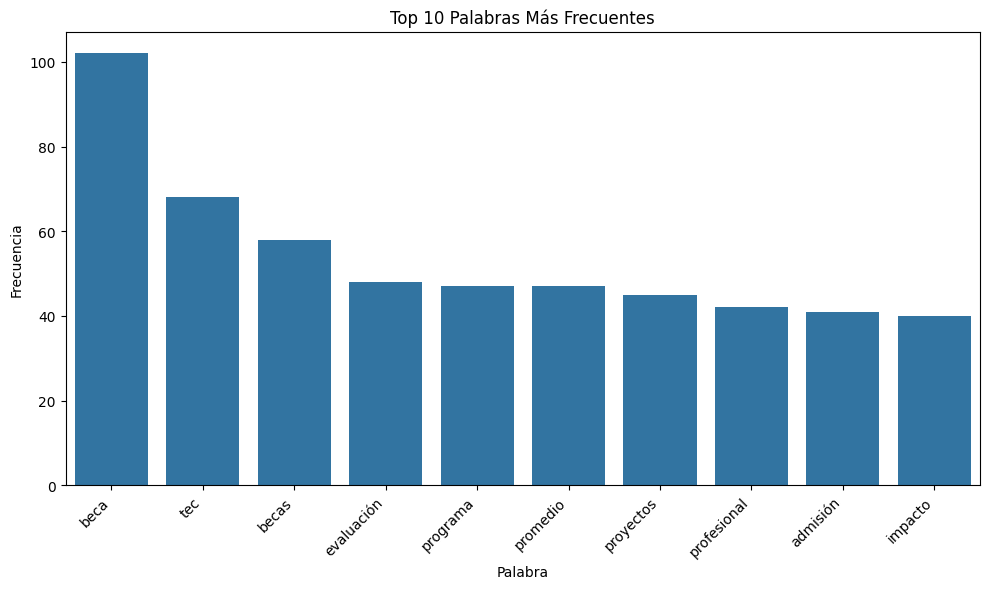

In [174]:
# Obtener las 10 palabras más frecuentes y sus conteos
top_10_palabras = frecuencia_palabras.most_common(10)
palabras = [word for word, count in top_10_palabras]
conteos = [count for word, count in top_10_palabras]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=palabras, y=conteos)
plt.title('Top 10 Palabras Más Frecuentes')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [175]:
# -------------------------------------------------------------------------
# ANÁLISIS DE N-GRAMAS (BIGRAMAS Y TRIGRAMAS)
#
# En el dominio del TecBot, muchos conceptos clave son compuestos
# (ej. "Préstamo Educativo", "Servicio Social", "Examen de Admisión").
#
# Analizar bigramas nos permite identificar entidades compuestas que el
# Multiagente deberá reconocer como una sola unidad de intención, evitando
# ambigüedades en la recuperación de información.
# -------------------------------------------------------------------------
bigramas = list(nltk.bigrams(todas_las_palabras))
frecuencia_bigramas = Counter(bigramas)

print("\n--- Top 5 conceptos compuestos (Bigramas) ---")
print(frecuencia_bigramas.most_common(5))


--- Top 5 conceptos compuestos (Bigramas) ---
[(('número', 'becas'), 30), (('becas', 'limitado'), 24), (('promedio', 'mínimo'), 22), (('beca', 'talento'), 20), (('doble', 'titulación'), 17)]


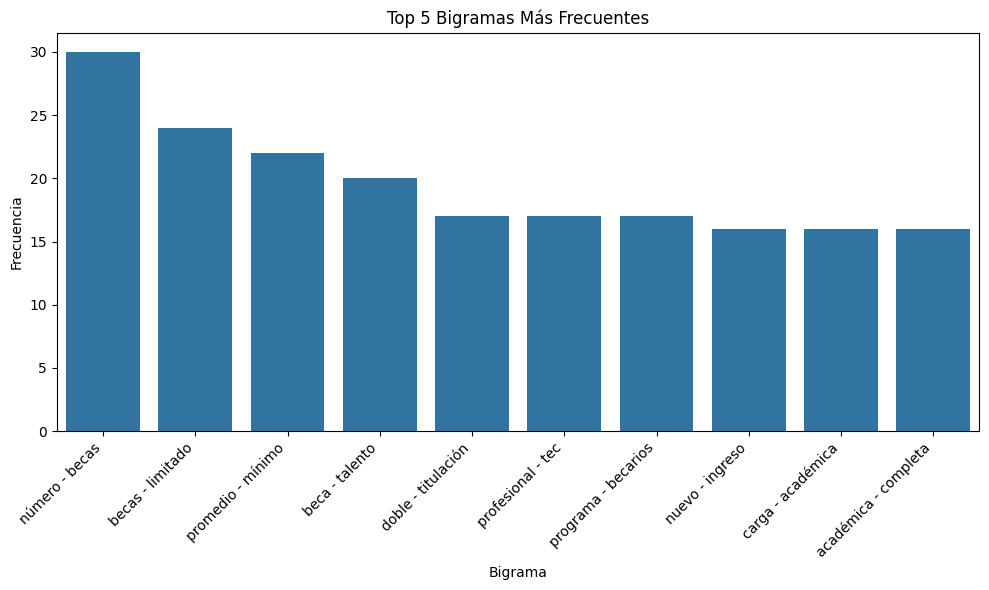

In [176]:
# Obtener los 5 bigramas más frecuentes y sus conteos
top_5_bigramas = frecuencia_bigramas.most_common(10)
bigramas_labels = [" - ".join(bigram) for bigram, count in top_5_bigramas]
conteos_bigramas = [count for bigram, count in top_5_bigramas]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=bigramas_labels, y=conteos_bigramas)
plt.title('Top 5 Bigramas Más Frecuentes')
plt.xlabel('Bigrama')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

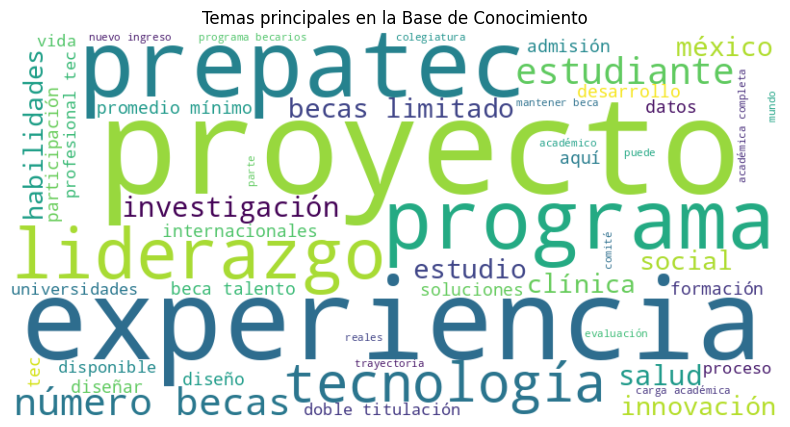

In [177]:
# -------------------------------------------------------------------------
# VISUALIZACIÓN GLOBAL DEL CORPUS (WORDCLOUD)
#
# Generación de una nube de palabras para una inspección visual rápida
# de los tópicos dominantes en la base de conocimiento.
#
# El tamaño de las palabras es proporcional a su frecuencia (post-limpieza).
# Esto nos confirma si los documentos cargados cubren los temas esperados
# (ej. admisiones, becas, campus) o si hay sesgos hacia un solo tema.
# -------------------------------------------------------------------------
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=50
).generate(" ".join(df['texto_limpio']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Temas principales en la Base de Conocimiento')
plt.show()

# 7. Análisis de Legibilidad y Estilo

En un chatbot institucional, la claridad del contenido impacta:

- qué tan rápido entiende el usuario,
- consistencia del tono/estilo,
- facilidad para generar respuestas extractivas o resumidas,
- calidad de “chunks” (textos muy densos suelen requerir reescritura o segmentación).

Por ello calculamos índices de legibilidad en español como:
- **Fernández-Huerta (1959)**: adaptación del enfoque de facilidad de lectura.
- **Gutiérrez de Polini (1972)**: índice de comprensibilidad para textos en español.

Estos indicadores sirven como señales exploratorias (no absolutas) para priorizar contenidos que podrían requerir normalización editorial (Fernández Huerta, 1959; Gutiérrez de Polini, 1972). Para su cálculo programático se emplea la librería `textstat`, que provee implementaciones prácticas de métricas de legibilidad (Textstat, 2025).

In [178]:
# -------------------------------------------------------------------------
# ANÁLISIS DE LEGIBILIDAD Y ESTILO (METRICAS DE TEXTO)
#
# Contexto TecBot:
# El chatbot atiende a aspirantes (público general), por lo que el lenguaje
# debe ser claro y accesible.
#
# - Utilizamos métricas como Fernández-Huerta para medir la complejidad.
# - Documentos con baja legibilidad ("Difíciles") son alertas para el diseño
#   del Prompt del Agente: se le deberá instruir explícitamente que
#   "simplifique" o "resuma" la información técnica al responder.
# -------------------------------------------------------------------------

# Configurar textstat para español
textstat.set_lang('es')

# 1. Función para calcular métricas de estilo
def analizar_estilo(texto):
    return pd.Series({
        'lecturabilidad_huerta': textstat.fernandez_huerta(texto),
        'dificultad_lectura': textstat.gutierrez_polini(texto),
        'conteo_silabas': textstat.syllable_count(texto),
        'promedio_palabras_por_frase': textstat.avg_sentence_length(texto)
    })

# 2. Aplicar el análisis al cuerpo de los artículos
estilo_df = df['Cuerpo_del_Articulo__c'].apply(analizar_estilo)
df_final = pd.concat([df, estilo_df], axis=1)

# 3. Categorizar el resultado de Fernández-Huerta
# 90-100: Muy fácil | 60-70: Estándar | 0-30: Muy difícil
def interpretar_huerta(score):
    if score >= 80: return 'Muy Fácil'
    elif score >= 60: return 'Estándar'
    elif score >= 30: return 'Difícil'
    else: return 'Muy Difícil'

df_final['Nivel_Lectura'] = df_final['lecturabilidad_huerta'].apply(interpretar_huerta)

# --- RESULTADOS ---
print("--- Resumen de Legibilidad ---")
display(df_final[['Title', 'lecturabilidad_huerta', 'Nivel_Lectura', 'promedio_palabras_por_frase']])

--- Resumen de Legibilidad ---


,Title,lecturabilidad_huerta,Nivel_Lectura,promedio_palabras_por_frase
0,Urbanismo - ¿Dónde podrás trabajar?,3.440000,Muy Difícil,20.000000
1,Urbanismo - ¿Por qué estudiar Urbanismo en el ...,39.901739,Difícil,23.000000
2,Ventajas del préstamo educativo,77.012585,Estándar,8.200000
3,Vida y Acompañamiento en PrepaTec,44.972568,Difícil,9.250000
4,¿Cómo se paga el Préstamo Educativo?,62.027547,Estándar,17.666667
...,...,...,...,...
298,Admisiones Tec de Monterrey - Políticas y regl...,-6.350909,Muy Difícil,55.000000
299,Admisiones Tec de Monterrey - Constos y colegi...,20.091579,Muy Difícil,19.000000
300,Admisiones Tec de Monterrey - Consideraciones ...,59.460870,Difícil,15.333333
301,Admisiones Tec de Monterrey - Calendario acadé...,-70.400000,Muy Difícil,12.000000



--- Distribución de Niveles ---


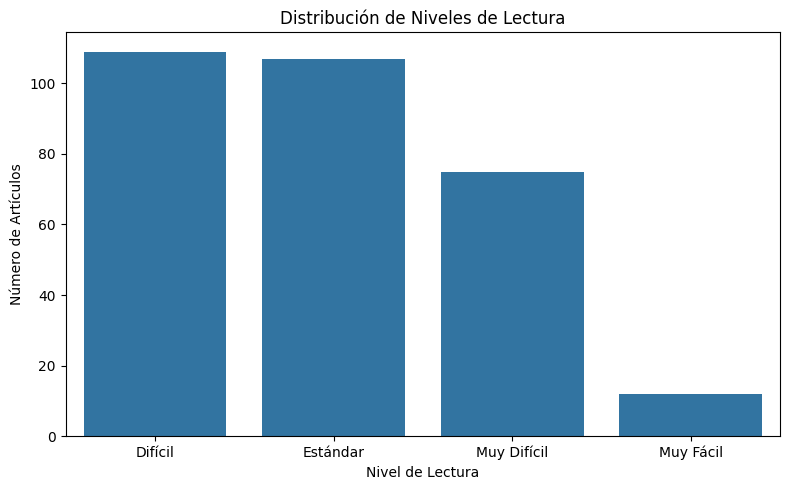

In [179]:
print("\n--- Distribución de Niveles ---")

# Visualización de la distribución de Nivel_Lectura
plt.figure(figsize=(8, 5))
sns.barplot(x=df_final['Nivel_Lectura'].value_counts().index,
            y=df_final['Nivel_Lectura'].value_counts().values)
plt.title('Distribución de Niveles de Lectura')
plt.xlabel('Nivel de Lectura')
plt.ylabel('Número de Artículos')
plt.tight_layout()
plt.show()

# 8. Conclusiones


In [180]:
from IPython.display import display, Markdown

# --- Construcción narrativa (automática) con base en resultados ya calculados en el notebook ---
n_rows, n_cols = df.shape
missing_rate = df.isnull().mean()
missing_cols = missing_rate[missing_rate > 0].sort_values(ascending=False)

# Duplicados (si existen variables previas)
dup_article = df.duplicated(subset=["ArticleNumber"]).sum() if "ArticleNumber" in df.columns else None
dup_urlname = df.duplicated(subset=["UrlName"]).sum() if "UrlName" in df.columns else None

# Outliers (si existe el dataframe outliers)
outlier_n = outliers.shape[0] if "outliers" in globals() else None
outlier_pct = (outlier_n / n_rows * 100) if outlier_n is not None and n_rows else None

# Cardinalidad
cat_nunique = df["Category"].nunique() if "Category" in df.columns else None

# Sesgo (si ya calculaste skews)
wc_skew = skews["word_count"] if "skews" in globals() and "word_count" in skews else None

# Legibilidad (si ya calculaste df_final)
has_readability = "df_final" in globals() and "fernandez_huerta" in df_final.columns and "gutierrez_polini" in df_final.columns

# Texto principal
parts = []
parts.append(f"El conjunto analizado contiene **{n_rows:,} registros** y **{n_cols} variables**. "
             f"Al tratarse de una base textual para un caso de uso de chatbot/RAG, el EDA se enfocó en completitud, redundancia y propiedades del texto.")

if len(missing_cols) > 0:
    top_miss = missing_cols.index[0]
    top_miss_pct = missing_cols.iloc[0] * 100
    parts.append(f"Se identificaron **valores faltantes**, destacando **{top_miss}** como la variable con mayor ausencia (**{top_miss_pct:.1f}%**). "
                 f"Esto sugiere priorizar reglas de validación/normalización para campos críticos antes de indexación o evaluación.")
else:
    parts.append("No se observaron valores faltantes relevantes en el conjunto, lo que facilita la estandarización previa al pipeline de recuperación.")

if dup_article is not None or dup_urlname is not None:
    dmsg = []
    if dup_article is not None:
        dmsg.append(f"duplicados por `ArticleNumber` = **{dup_article:,}**")
    if dup_urlname is not None:
        dmsg.append(f"duplicados por `UrlName` = **{dup_urlname:,}**")
    parts.append("En cuanto a consistencia, se revisaron posibles duplicados (" + ", ".join(dmsg) + "). "
                 "Este punto es clave para evitar contenido redundante que distorsione recuperación y métricas.")

if outlier_n is not None:
    parts.append(f"Respecto a documentos atípicos por longitud (regla IQR), se detectaron **{outlier_n:,}** registros "
                 f"(**{outlier_pct:.1f}%**). Esto respalda la necesidad de una política explícita de **chunking** y revisión de formatos anómalos.")

if cat_nunique is not None:
    parts.append(f"La variable **Category** presenta una cardinalidad de **{cat_nunique:,}**. "
                 "Para reporteo se recomienda top-N + 'Otros', y para modelado evitar codificaciones que inflen dimensionalidad sin control.")

if has_readability:
    fh_mean = df_final["fernandez_huerta"].mean()
    gp_mean = df_final["gutierrez_polini"].mean()
    parts.append(f"Finalmente, el análisis de legibilidad sugiere niveles promedio de comprensión acordes al corpus "
                 f"(Fernández-Huerta promedio **{fh_mean:.1f}**, Gutiérrez de Polini promedio **{gp_mean:.1f}**), "
                 "aportando una señal adicional para priorizar contenidos potencialmente densos o difíciles de leer.")

final_text = " ".join(parts)
display(Markdown(final_text))

El conjunto analizado contiene **303 registros** y **8 variables**. Al tratarse de una base textual para un caso de uso de chatbot/RAG, el EDA se enfocó en completitud, redundancia y propiedades del texto. No se observaron valores faltantes relevantes en el conjunto, lo que facilita la estandarización previa al pipeline de recuperación. En cuanto a consistencia, se revisaron posibles duplicados (duplicados por `ArticleNumber` = **0**, duplicados por `UrlName` = **0**). Este punto es clave para evitar contenido redundante que distorsione recuperación y métricas. Respecto a documentos atípicos por longitud (regla IQR), se detectaron **11** registros (**3.6%**). Esto respalda la necesidad de una política explícita de **chunking** y revisión de formatos anómalos. La variable **Category** presenta una cardinalidad de **44**. Para reporteo se recomienda top-N + 'Otros', y para modelado evitar codificaciones que inflen dimensionalidad sin control.

El Análisis Exploratorio de Datos permitió comprender de manera integral la estructura, calidad y características del corpus textual que servirá como base de conocimiento para el desarrollo del sistema TecBot bajo una arquitectura RAG y multiagente. A diferencia de un EDA tradicional orientado a variables numéricas, este análisis se centró en señales textuales, distribución documental y legibilidad, aspectos críticos para sistemas de recuperación y generación de lenguaje natural.

Los resultados evidencian que el conjunto de datos presenta una estructura consistente y adecuada para su explotación, aunque con oportunidades claras de mejora en términos de normalización, deduplicación y segmentación de documentos. La distribución de longitudes muestra la coexistencia de textos muy cortos y documentos extensos, lo cual justifica la necesidad de aplicar estrategias de chunking controlado para optimizar la generación de embeddings y la recuperación semántica.

Asimismo, el análisis de cardinalidad confirmó la presencia de campos categóricos con alta diversidad, lo que sugiere tratarlos como metadatos de filtrado o señales auxiliares, en lugar de codificaciones directas que puedan inflar innecesariamente la complejidad del sistema. La evaluación de similitud textual y frecuencia de términos permitió identificar posibles redundancias y solapamientos temáticos, lo que abre la puerta a procesos de curaduría y consolidación del conocimiento.

Finalmente, las métricas de legibilidad indican que, si bien gran parte del contenido es comprensible, existen variaciones significativas en el estilo y la complejidad del lenguaje, lo que podría impactar la experiencia del usuario final y la calidad de las respuestas generadas. Estas métricas se consideran indicadores exploratorios clave para priorizar la reescritura o estandarización editorial de ciertos documentos.

En conjunto, este EDA cumple su objetivo fundamental: reducir la incertidumbre antes del modelado, establecer criterios claros para la preparación de datos y sentar las bases técnicas para las siguientes fases del proyecto, incluyendo la ingeniería de chunks, la selección de embeddings, el diseño de la capa de recuperación y la orquestación de agentes LLM de forma escalable y controlable.

Este análisis exploratorio se posiciona como la base técnica necesaria para la evaluación comparativa de arquitecturas multiagentes en Microsoft Agent y LangGraph, garantizando que las diferencias observadas en desempeño, escalabilidad y control respondan al diseño de los agentes y no a inconsistencias del conocimiento subyacente.

# 9. Bibliografía

- Aggarwal, C. C. (2017). Outlier Analysis (2nd ed.). Springer. https://sadbhavnapublications.org/research-enrichment-material/2-Statistical-Books/Outlier-Analysis.pdf

- Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction (2nd ed.). Springer. https://www.sas.upenn.edu/~fdiebold/NoHesitations/BookAdvanced.pdf

- Wickham, H., & Grolemund, G. (2016). R for Data Science: Import, Tidy, Transform, Visualize, and Model Data. O’Reilly Media. https://www.oreilly.com/library/view/r-for-data/9781491910382/

- Box, G. E. P., & Cox, D. R. (1964). An analysis of transformations. Journal of the Royal Statistical Society: Series B (Methodological), 26(2), 211–252. https://doi.org/10.1111/j.2517-6161.1964.tb00553.x

- Fernández Huerta, J. (1959). Medidas sencillas de lecturabilidad. Consigna, (214), 29–32. https://legible.es/blog/lecturabilidad-fernandez-huerta/)

- Gutiérrez de Polini, L. E. (1972). Investigación sobre lectura en Venezuela. Ministerio de Educación. https://legible.es/blog/comprensibilidad-gutierrez-de-polini/)

- Micci-Barreca, D. (2001). A preprocessing scheme for high-cardinality categorical attributes in classification and prediction problems. ACM SIGKDD Explorations Newsletter, 3(1), 27–32. https://doi.org/10.1145/507533.507538

- Salton, G., & Buckley, C. (1988). Term-weighting approaches in automatic text retrieval. Information Processing & Management, 24(5), 513–523. https://doi.org/10.1016/0306-4573(88)90021-0

- Textstat. (2025). textstat (Version 0.7.12) [Software]. Python Package Index. https://pypi.org/project/textstat/

- Wickham, H. (2014). Tidy data. Journal of Statistical Software, 59(10), 1–23. https://doi.org/10.18637/jss.v059.i10

- Deerwester, S., Dumais, S. T., Furnas, G. W., Landauer, T. K., & Harshman, R. (1990). Indexing by latent semantic analysis. Journal of the American Society for Information Science, 41(6), 391–407.  https://doi.org/10.1002/(SICI)1097-4571(199009)41:6%3C391::AID-ASI1%3E3.0.CO;2-9

- Little, R. J. A., & Rubin, D. B. (2019). Statistical Analysis with Missing Data (3rd ed.). Wiley. https://doi.org/10.1002/9781119482260

- Manning, C. D., Raghavan, P., & Schütze, H. (2008). Introduction to Information Retrieval. Cambridge University Press. https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf

- Tukey, J. W. (1977). Exploratory Data Analysis. Addison-Wesley. https://archive.org/details/exploratorydataa0000tuke_7616